# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

PATH_train = 'D:/data/train/'
PATH_test = 'D:/data/test1/'

# 1. 훈련 데이터

In [2]:
filenames = os.listdir(PATH_train)
categories = []
for filename in filenames:
    category = filename.split('.')[0] 
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

data = pd.DataFrame({
    'filename': filenames,
    'category': categories
}).sort_index()

data.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [3]:
data.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


data length: 25000


<AxesSubplot: >

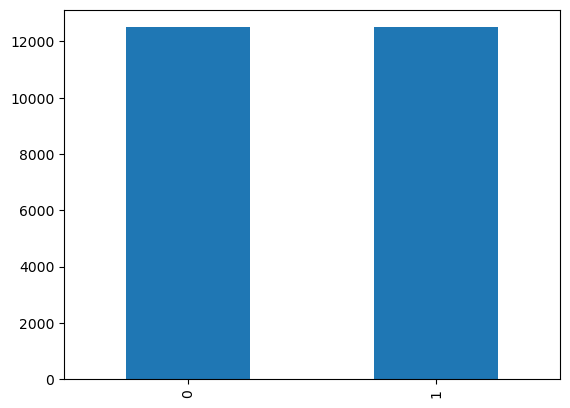

In [4]:
print("data length:", len(data))

data["category"].value_counts().plot.bar()

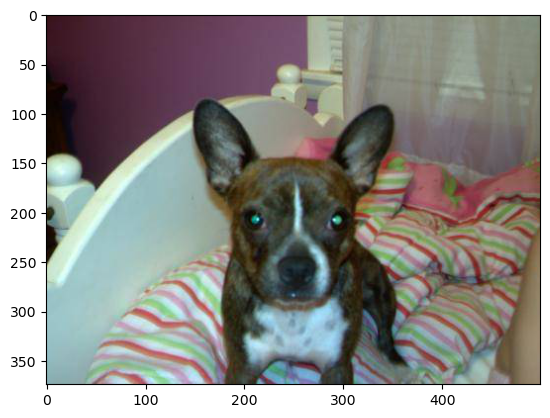

In [5]:
from tensorflow.keras.preprocessing.image import load_img

random_img = random.choice(filenames)
img = load_img(PATH_train + random_img)
plt.imshow(img)

20000 5000


<AxesSubplot: >

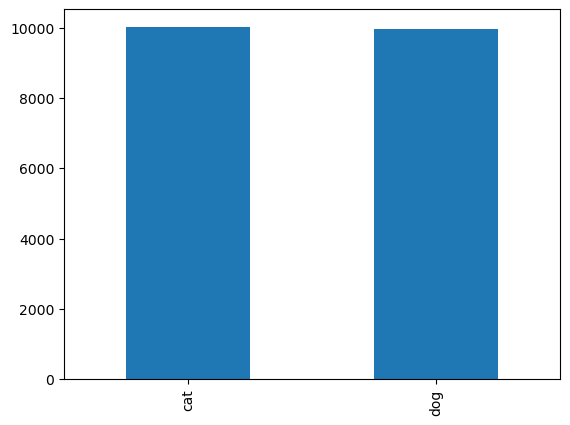

In [6]:
from sklearn.model_selection import train_test_split

data["category"] = data["category"].replace({0: 'cat', 1: 'dog'})

train_data, val_data = train_test_split(data, test_size=0.2, random_state=333)
print(len(train_data), len(val_data)) # train.shape[0], test.shape[0]

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

train_data['category'].value_counts().plot.bar()


In [7]:
total_train = train_data.shape[0]
total_val = val_data.shape[0]

print(train_data, total_val)

            filename category
0        cat.653.jpg      cat
1       cat.2740.jpg      cat
2       dog.5670.jpg      dog
3        cat.340.jpg      cat
4       cat.7949.jpg      cat
...              ...      ...
19995   cat.3693.jpg      cat
19996   dog.9024.jpg      dog
19997   dog.7704.jpg      dog
19998  cat.10873.jpg      cat
19999   cat.6102.jpg      cat

[20000 rows x 2 columns] 5000


In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 16

train_data_Gen = ImageDataGenerator (
    rescale = 1./255,
    horizontal_flip = True,         # 수평선을 기준으로 반전
    vertical_flip = True,           # 수직선을 기준으로 반전
    width_shift_range = 0.1,        # 10% 만큼 가로 이동
    height_shift_range = 0.1,       # 10% 만큼 세로 이동
    rotation_range = 5,             # 회전
    zoom_range = 0.2,               # 확대
    shear_range = 0.2,              # 엇갈림
    fill_mode = 'nearest'  
    )

train_Gen = train_data_Gen.flow_from_dataframe (
    train_data,
    'D:/data/train/',
    x_col='filename',
    y_col='category',
    target_size=image_size,         
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_Gen = ImageDataGenerator (
    rescale = 1./255,
    )

val_Gen = train_data_Gen.flow_from_dataframe (
    val_data,
    'D:/data/train/',
    x_col='filename',
    y_col='category',
    target_size=image_size,       
    batch_size=batch_size,
    class_mode='categorical'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# 2. 모델

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(64, (2,2), input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 128)       0

# 3. 컴파일, 훈련

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics='acc')

ES = EarlyStopping(monitor='val_acc', 
                   mode='auto',
                   patience=8,
                   restore_best_weights=True)

LR = ReduceLROnPlateau(monitor='val_acc', 
                       patience=2, 
                       factor=0.5, 
                       min_lr=0.00001)

hist = model.fit_generator(
    train_Gen, 
    epochs=4,
    steps_per_epoch=total_train//batch_size,
    validation_data=val_Gen,
    validation_steps=total_val//batch_size,
    callbacks=[ES, LR]
)

val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
print('val_acc',val_acc[-1])
print('val_loss',val_loss[-1])

C:\Users\bitcamp\AppData\Local\Temp\ipykernel_30680\2071749440.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/4
1250/1250 [==============================] - 150s 118ms/step - loss: 0.7389 - acc: 0.5925 - val_loss: 0.6271 - val_acc: 0.6619 - lr: 0.0010
Epoch 2/4
1250/1250 [==============================] - 118s 94ms/step - loss: 0.6430 - acc: 0.6387 - val_loss: 0.6444 - val_acc: 0.6324 - lr: 0.0010
Epoch 3/4
1250/1250 [==============================] - 114s 91ms/step - loss: 0.6253 - acc: 0.6609 - val_loss: 0.6208 - val_acc: 0.6560 - lr: 0.0010
Epoch 4/4
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5698 - acc: 0.7130 - val_loss: 0.5659 - val_acc: 0.7101 - lr: 5.0000e-04
val_acc 0.7101362347602844
val_loss 0.5659117102622986


# 4. 예측 데이터

In [11]:
test_filenames = os.listdir(PATH_test)
test_data = pd.DataFrame({
    'filename': test_filenames
})

total_test = test_data.shape[0]
print(len(test_data))

test_data_gen = ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_dataframe(
    test_data, 
    PATH_test,    
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

12500
Found 12500 validated image filenames.


# 5. 예측

In [12]:
predict = model.predict_generator(test_gen, steps = np.ceil(total_test/batch_size))

C:\Users\bitcamp\AppData\Local\Temp\ipykernel_30680\2705724582.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_gen, steps = np.ceil(total_test/batch_size))


<AxesSubplot: >

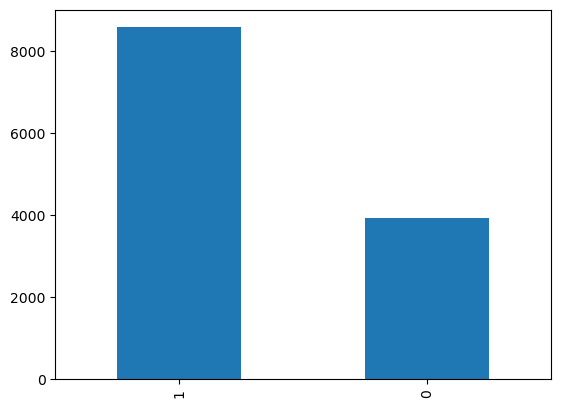

In [13]:
test_data['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_Gen.class_indices.items())
test_data['category'] = test_data['category'].replace(label_map)

test_data['category'] = test_data['category'].replace({ 'dog': 1, 'cat': 0 })

test_data['category'].value_counts().plot.bar()

 # submission

In [16]:
submission = test_data.copy()
submission['id'] = submission['filename'].str.split('.').str[0]
submission['label'] = submission['category']
submission.drop(['filename', 'category'], axis=1, inplace=True)
submission.to_csv('C:/study/keras/keras_data/cat_dog/submission.csv', index=False)